# Robustness

- [Training Dataset](https://huggingface.co/datasets/uoft-cs/cifar10)
- [Corrupt Dataset](https://huggingface.co/datasets/robro/cifar10-c-parquet)

```
[1] D. Hendrycks and T. Dietterich, “Benchmarking Neural Network Robustness to Common Corruptions and Perturbations,” Mar. 28, 2019, arXiv: arXiv:1903.12261. doi: 10.48550/arXiv.1903.12261.
[1] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” Dec. 10, 2015, arXiv: arXiv:1512.03385. doi: 10.48550/arXiv.1512.03385.
```

---

- Dataaset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
- https://debuggercafe.com/building-resnets-from-scratch-using-pytorch/
- https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

## Install

In [75]:
%pip install torch torchvision matplotlib numpy scikit-learn tqdm pandas datasets torchinfo

Note: you may need to restart the kernel to use updated packages.


## Import

In [76]:
import torch
import numpy as np
from tqdm import tqdm

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

SEED=42
np.random.seed(SEED)

Device: mps


## Load CIFAR10 and CIFAR10-C

In [78]:
from datasets import load_dataset

t_dataset = load_dataset("cifar10", split="train", trust_remote_code=False)
r_dataset = load_dataset("robro/cifar10-c-parquet", split="train", trust_remote_code=False)
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck",]

# Shuffle the full datasets
t_dataset = t_dataset.shuffle(seed=SEED)
r_dataset = r_dataset.shuffle(seed=SEED)

#########################################
# Just to look at the datasets
t_df_dataset = t_dataset.to_pandas()
r_df_dataset = r_dataset.to_pandas()
display(t_df_dataset)
display(r_df_dataset)

,img,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,2
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,6
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,7
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,9
...,...,...
49995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3
49996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1
49997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1
49998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3


,image,label,corruption_name,corruption_level
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,snow,1
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,2,spatter,5
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,4,frost,3
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,8,gaussian_noise,4
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3,saturate,5
...,...,...,...,...
949995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,6,frost,2
949996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,frost,3
949997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,6,spatter,4
949998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,5,spatter,3


### Display Image Sample

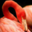

Label: bird


In [79]:
from PIL import Image
import io

example = t_df_dataset.iloc[1]
image = example["img"]
label = example["label"]

stream = io.BytesIO(image['bytes'])
img = Image.open(stream)

display(img)
print(f"Label: {classes[label]}")

## Mean and Std of the Datasets

In [80]:
if False:
    import torch
    import torchvision.transforms as transforms

    def make_tensor_map(col: str):
        def pil_to_tensor(row):
            if isinstance(row[col], dict) and "bytes" in row[col]:
                img = Image.open(io.BytesIO(row[col]["bytes"]))
            elif isinstance(row[col], bytes):
                img = Image.open(io.BytesIO(row[col]))
            else:
                img = row[col]
            row["pixel_values"] = transforms.ToTensor()(img)
            return row
        return pil_to_tensor

    def calculate_mean_std(dataset):
        # Stack all the tensors in the dataset into a single 4D tensor of shape (num_images, 3, 32, 32).
        pixel_values = [torch.tensor(example["pixel_values"]) for example in dataset]
        all_images = torch.stack(pixel_values)
        # Calculate mean and std for each channel (R, G, B)
        mean = all_images.mean(dim=[0, 2, 3])  # batch, height, width
        std = all_images.std(dim=[0, 2, 3])
        return mean, std

    t_dataset = t_dataset.map(make_tensor_map("img"))
    r_dataset = r_dataset.map(make_tensor_map("image"))
    # display(t_dataset.to_pandas())
    t_mean, t_std = calculate_mean_std(t_dataset)
    r_mean, r_std = calculate_mean_std(r_dataset)

    print(f"Mean: {t_mean} Std: {t_std}")
    print(f"Mean: {r_mean} Std: {r_std}")

    # Output
    # Mean: tensor([0.4914, 0.4822, 0.4465]) Std: tensor([0.2470, 0.2435, 0.2616])
    # Mean: tensor([0.5115, 0.5040, 0.4701]) Std: tensor([0.2429, 0.2397, 0.2590])

## Augment and Normalize the Datasets

Here we are augmenting the training dataset with some slight tweaks to better train the model (flipping, etc). This helps the model become more robust to small variations, which is good generalization (we can remove this if needed).

We **do not** augment the curropt dataset, but we do normalize it.

In [81]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Base transforms that simply apply normalization
base_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize(mean, std): Normalizes the tensor using the mean and standard
    # deviation of the CIFAR-10 dataset.
    # => Mean: tensor([0.4914, 0.4822, 0.4465]) Std: tensor([0.2470, 0.2435, 0.2616])
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
# Augmented transform that applies normalization and adds some random
# tweaks to images to help with robustness
aug_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
# Corrupt dataset transform that just does normaliztion for the dataset
corrupt_transform = transforms.Compose([
    transforms.ToTensor(),
    # => Mean: tensor([0.5115, 0.5040, 0.4701]) Std: tensor([0.2429, 0.2397, 0.2590])
    transforms.Normalize((0.5115, 0.5040, 0.4701), (0.2429, 0.2397, 0.2590)),
])

##################################
# Apply the base transform to the base training set
def base_transform_fn(row):
    row["pixel_values"] = [base_transform(image.convert("RGB")) for image in row["img"]]
    row["labels"] = [int(label) for label in row["label"]]
    return row
t_dataset.set_transform(base_transform_fn)

# Apply corrupt transform the the robustness dataset
def corrupt_transform_fn(row):
    row["pixel_values"] = [corrupt_transform(image.convert("RGB")) for image in row["image"]]
    row["labels"] = [int(label) for label in row["label"]]
    return row
r_dataset.set_transform(corrupt_transform_fn)

##################################
# collate in a DataLoader is used to combine data samples into batches
# to help during training to extract the data fields we care about
# see model training below
def collate_fn(row):
    pixel_values = torch.stack([example["pixel_values"] for example in row])
    labels = torch.tensor([example["labels"] for example in row])
    return pixel_values, labels

### Training Dataset

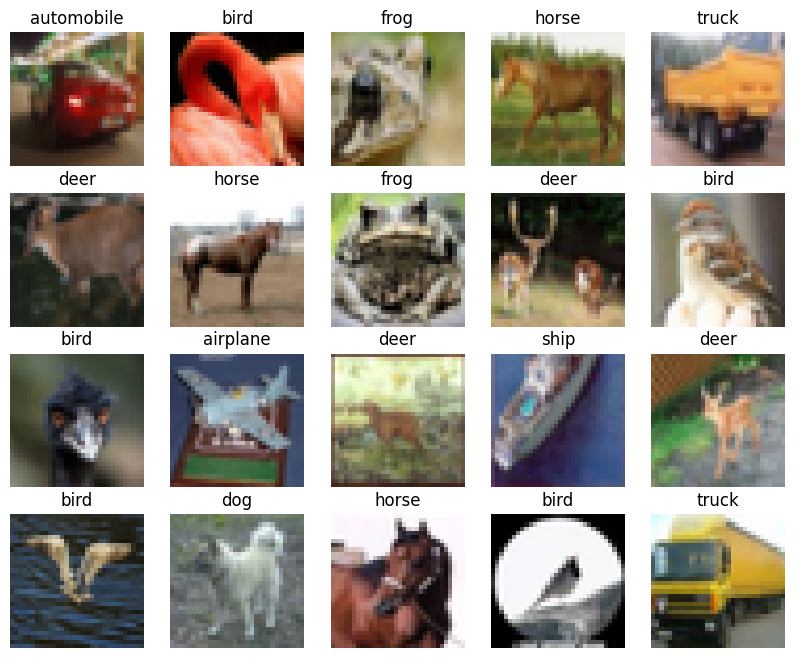

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,5,figsize=(10,8))
for i, c in enumerate(t_dataset):
    x, y = i//5, i%5
    ax[x][y].set_title(classes[t_dataset[i]["label"]])
    ax[x][y].axis('off')
    ax[x][y].imshow(t_dataset[i]["img"])
    if i == 19:
        break

### Robustness Dataset

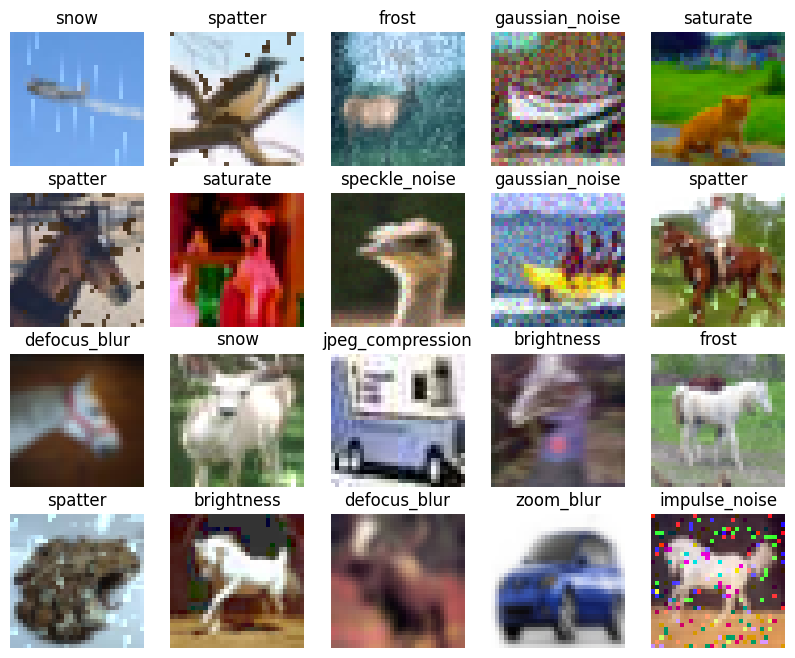

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,5,figsize=(10,8))
for i, c in enumerate(r_dataset):
    x, y = i//5, i%5
    ax[x][y].set_title(r_dataset[i]["corruption_name"])
    ax[x][y].axis('off')
    ax[x][y].imshow(r_dataset[i]["image"])
    if i == 19:
        break

----

# Models

## ResNet-8 Model

ResNet-8:

- Input: 32x32 (CIFAR-10)
- Channels: 16 → 32 → 64
- Blocks: 2 per stage (total 6 blocks + initial conv)
- Parameters: ~0.3M–0.7M (can adjust channels to match ViT-Tiny)

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

There are 3 main components that make up the ResNet.

1. input layer (conv1 + max pooling) (Usually referred to as layer 0)
2. ResBlocks (conv2 without max pooing ~ conv5) (Usually referred to as layer1 ~ layer4)
3. final layer

In [85]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [86]:
class ResNet8(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Start with 16 channels
        self.in_channels = 16

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Two layers per stage, with channel doubling each stage
        self.layer1 = self._make_layer(16, 2, stride=1)  # 16 channels
        self.layer2 = self._make_layer(32, 2, stride=2)  # 32 channels
        self.layer3 = self._make_layer(64, 2, stride=2)  # 64 channels

        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)  # Global average pool for 32x32 input
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [87]:
from torchinfo import summary

resnet8 = ResNet8(10).to(device)
summary(resnet8, (1, 3, 32, 32))  # Batch size of 1

Layer (type:depth-idx)                   Output Shape              Param #
ResNet8                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─Sequential: 1-3                        [1, 16, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─Conv2d: 3-3                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-4             [1, 16, 32, 32]           32
│    │    └─Sequential: 3-5              [1, 16, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    

### Train ResNet-8

In [ ]:
import torch.optim as optim

CFG = {
    "classes": classes,
    "batch_size": 256,
    "epochs": 30,
    "lr": 0.001, # 0.01
    "weight_decay": 0.0001,
    "use_aug": True,
}

model = ResNet8(len(CFG["classes"])).to(device)

optimizer = optim.SGD(model.parameters(), lr=CFG["lr"])
loss = nn.CrossEntropyLoss()

# Split training and testing by 20%
train_test_ds = t_dataset.train_test_split(test_size=0.2)

train_loader = DataLoader(train_test_ds['train'], batch_size=CFG["batch_size"], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(train_test_ds['test'], batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn)

# train = train_test_ds['train'].to_pandas()
# test = train_test_ds['test'].to_pandas()
# display(train)
# display(test)

In [89]:
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0

    for i, data in tqdm(enumerate(loader), total=len(loader)):
        counter += 1

        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # Forward pass
        outputs = model(image)
        loss = loss_fn(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc


In [90]:
def validate(model, loader, loss_fn, device):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(image)
            # Calculate the loss
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(loader.dataset))
    return epoch_loss, epoch_acc

In [91]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, loss, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, loss, device)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    # print(f"Train loss: {train_epoch_loss:.3f}, acc: {train_epoch_acc:.3f}")
    # print(f"Valid loss: {valid_epoch_loss:.3f}, acc: {valid_epoch_acc:.3f}")

Epoch 1 of 30


100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Epoch 2 of 30


100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Epoch 3 of 30


100%|██████████| 40/40 [00:01<00:00, 28.31it/s]


Epoch 4 of 30


100%|██████████| 40/40 [00:01<00:00, 28.35it/s]


Epoch 5 of 30


100%|██████████| 40/40 [00:01<00:00, 28.25it/s]


Epoch 6 of 30


100%|██████████| 40/40 [00:01<00:00, 28.29it/s]


Epoch 7 of 30


100%|██████████| 40/40 [00:01<00:00, 28.18it/s]


Epoch 8 of 30


100%|██████████| 40/40 [00:01<00:00, 28.34it/s]


Epoch 9 of 30


100%|██████████| 40/40 [00:01<00:00, 28.16it/s]


Epoch 10 of 30


100%|██████████| 40/40 [00:01<00:00, 28.29it/s]


Epoch 11 of 30


100%|██████████| 40/40 [00:01<00:00, 28.52it/s]


Epoch 12 of 30


100%|██████████| 40/40 [00:01<00:00, 28.43it/s]


Epoch 13 of 30


100%|██████████| 40/40 [00:01<00:00, 28.36it/s]


Epoch 14 of 30


100%|██████████| 40/40 [00:01<00:00, 28.45it/s]


Epoch 15 of 30


100%|██████████| 40/40 [00:01<00:00, 28.40it/s]


Epoch 16 of 30


100%|██████████| 40/40 [00:01<00:00, 28.41it/s]


Epoch 17 of 30


100%|██████████| 40/40 [00:01<00:00, 27.94it/s]


Epoch 18 of 30


100%|██████████| 40/40 [00:01<00:00, 28.33it/s]


Epoch 19 of 30


100%|██████████| 40/40 [00:01<00:00, 28.48it/s]


Epoch 20 of 30


100%|██████████| 40/40 [00:01<00:00, 28.44it/s]


Epoch 21 of 30


100%|██████████| 40/40 [00:01<00:00, 26.83it/s]


Epoch 22 of 30


100%|██████████| 40/40 [00:01<00:00, 28.28it/s]


Epoch 23 of 30


100%|██████████| 40/40 [00:01<00:00, 28.34it/s]


Epoch 24 of 30


100%|██████████| 40/40 [00:01<00:00, 26.80it/s]


Epoch 25 of 30


100%|██████████| 40/40 [00:01<00:00, 28.37it/s]


Epoch 26 of 30


100%|██████████| 40/40 [00:01<00:00, 26.78it/s]


Epoch 27 of 30


100%|██████████| 40/40 [00:01<00:00, 28.25it/s]


Epoch 28 of 30


100%|██████████| 40/40 [00:01<00:00, 28.42it/s]


Epoch 29 of 30


100%|██████████| 40/40 [00:01<00:00, 28.24it/s]


Epoch 30 of 30


100%|██████████| 40/40 [00:01<00:00, 28.28it/s]


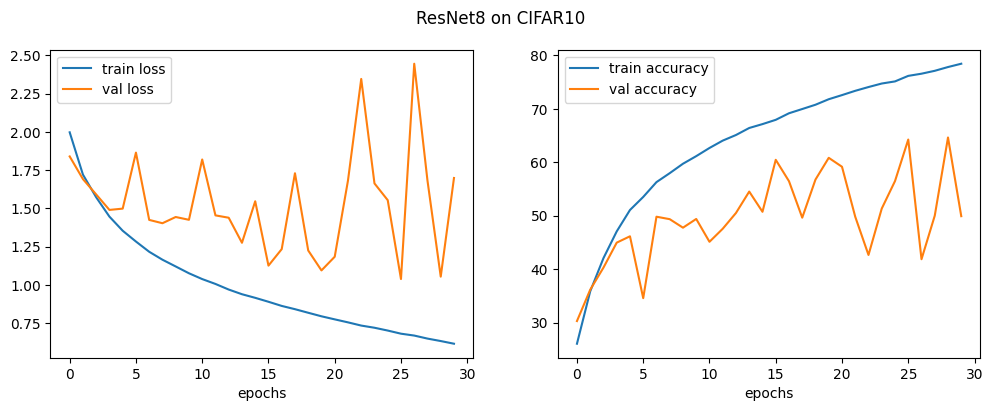

In [93]:
# print(train_loss)
# print(valid_loss)
# print(train_acc)
# print(valid_acc)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('ResNet8 on CIFAR10')
ax[0].set_xlabel('epochs')
ax[0].plot(train_loss, label='train loss')
ax[0].plot(valid_loss, label='val loss')
ax[0].legend()
ax[1].set_xlabel('epochs')
ax[1].plot(train_acc, label='train accuracy')
ax[1].plot(valid_acc, label='val accuracy')
ax[1].legend()
plt.show()